In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
pd.options.mode.chained_assignment = None
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import random

In [44]:
total_cows = pd.DataFrame()

dataDir = '../../Data/processed/'
total_cows = pd.read_csv(dataDir+'Cow_Prob_dataset_L1.csv')
total_cows


,FarmName_Pseudo,Gigacow_Cow_Id,Total_MilkProduction,Total_timeDelta_Seconds,MilkingDate,LactationNumber,DaysInMilk,BreedName,Age,problematic,id
0,a624fb9a,2560,9.38,3176.0,2022-02-14,1.0,2.0,1,2.15,0,1
1,a624fb9a,2560,8.46,352.0,2022-02-14,1.0,2.0,1,2.15,0,1
2,a624fb9a,2560,6.68,997.0,2022-02-15,1.0,3.0,1,2.15,0,1
3,a624fb9a,2560,7.34,9274.0,2022-02-15,1.0,3.0,1,2.15,0,1
4,a624fb9a,2560,8.15,407.0,2022-02-16,1.0,4.0,1,2.15,0,1
...,...,...,...,...,...,...,...,...,...,...,...
95849,a624fb9a,2047,7.96,59.0,2022-11-12,1.0,322.0,1,3.02,0,142
95850,a624fb9a,2047,5.53,148.0,2022-11-13,1.0,323.0,1,3.03,0,142
95851,a624fb9a,2047,3.24,287.0,2022-11-13,1.0,323.0,1,3.03,0,142
95852,a624fb9a,2047,9.23,240.0,2022-11-13,1.0,323.0,1,3.03,0,142


In [45]:
total_cows_SRB1 = total_cows[total_cows['BreedName'] == 1]

total_cows = total_cows_SRB1

In [64]:
# Select IDs from the total_cows
test_cow_list = []
ids = total_cows['id']

unique_cow_ids = ids.unique()

# Select a few rows randomly
num_of_selected_cows = 5

#test_cow_list = [1]

#test_cow_list = random.choices( unique_cow_ids, k=num_of_selected_cows)
#test_cow_list.sort()

test_cow_list_SRB1 =  [20, 46, 20, 75, 63]
test_cow_list = test_cow_list_SRB1
print(test_cow_list, len(test_cow_list))

[20, 46, 20, 75, 63] 5


In [309]:
modified_total_cows = total_cows
ts_length_test_data = 105

for l in test_cow_list:
    # Choose a specific duration
    condition = modified_total_cows['id'] == l
    test_cow = modified_total_cows[condition].copy()
    test_cow = test_cow.reset_index()        
    # print(test_cow)
    if 'index' in test_cow:
        test_cow = test_cow.drop('index', axis=1)
        
    modified_total_cows = modified_total_cows[~condition]
            
    test_cow['MilkingDate'] = pd.to_datetime(test_cow['MilkingDate'])
    test_cow['MilkingDate'] = test_cow['MilkingDate'].dt.date
            
    start_date = test_cow['MilkingDate'][0]
    #print('start_date: ',start_date)
    end_date = pd.to_datetime(start_date + pd.DateOffset(days=ts_length_test_data)).date()
    #print('end_date: ', end_date)
    filtered_df = test_cow[(test_cow['MilkingDate'] >= start_date) & (test_cow['MilkingDate'] <= end_date)]   
    
    modified_total_cows = pd.concat([modified_total_cows, filtered_df], ignore_index=True)
    

#modified_total_cows = modified_total_cows.drop('index', axis=1)
#modified_total_cows = modified_total_cows.sort_values('id')
modified_total_cows = modified_total_cows.sort_values(by=['id', 'MilkingDate'])

modified_total_cows.to_csv(dataDir+"upp.csv", index=False)

#modified_total_cows = modified_total_cows.reset_index()

modified_total_cows.tail()

,FarmName_Pseudo,Gigacow_Cow_Id,Total_MilkProduction,Total_timeDelta_Seconds,MilkingDate,LactationNumber,DaysInMilk,BreedName,Age,problematic,id
32845,a624fb9a,2047,7.96,59.0,2022-11-12,1.0,322.0,1,3.02,0,142
32846,a624fb9a,2047,5.53,148.0,2022-11-13,1.0,323.0,1,3.03,0,142
32847,a624fb9a,2047,3.24,287.0,2022-11-13,1.0,323.0,1,3.03,0,142
32848,a624fb9a,2047,9.23,240.0,2022-11-13,1.0,323.0,1,3.03,0,142
32849,a624fb9a,2047,7.42,10.0,2022-11-14,1.0,324.0,1,3.03,0,142


In [310]:
cow_total =  modified_total_cows
cow_total.shape


(33909, 11)

In [311]:
#original
#df_static_features = cow_total[['FarmName_Pseudo']]
static_cols = ['FarmName_Pseudo', 'TrafficDeviceName', 'LactationNumber', 'BreedName']
timeSeries_cols = ['Age', 'Total_MilkProduction', 'Total_timeDelta_Seconds', 'DaysInMilk']
output_col = ['problematic']

cow_label = cow_total[['id', 'problematic']].copy()
cow_timeseries = cow_total[['id', 'MilkingDate']].copy()
cow_timeseries.index = range(len(cow_timeseries))
# fetch y for feature extraction
y = cow_label.drop_duplicates(subset=['id'])
y = y["problematic"]
y.index = range(1,len(y)+1) 
print(y.value_counts())

0    44
1     4
Name: problematic, dtype: int64


In [312]:
#original
# Prepare datasert for Tsfresh extraction
ts_extracted_dataset = cow_total[['id']].copy()
print('ts_extracted_dataset shape: ', ts_extracted_dataset.shape)
ts_extracted_dataset.drop_duplicates(subset=['id'], inplace=True)
ts_extracted_dataset.index = range(1, len(ts_extracted_dataset)+1)
print('ts_extracted_dataset shape: ',ts_extracted_dataset.shape)

ts_processed = pd.DataFrame(cow_total[timeSeries_cols].copy())
ts_processed.index = range(0,len(ts_processed)) 

ts_processed = pd.concat([cow_timeseries, ts_processed], axis=1)
ts_processed

ts_extracted_dataset shape:  (33909, 1)
ts_extracted_dataset shape:  (48, 1)


,id,MilkingDate,Age,Total_MilkProduction,Total_timeDelta_Seconds,DaysInMilk
0,1,2022-02-14,2.15,9.38,3176.0,2.0
1,1,2022-02-14,2.15,8.46,352.0,2.0
2,1,2022-02-15,2.15,6.68,997.0,3.0
3,1,2022-02-15,2.15,7.34,9274.0,3.0
4,1,2022-02-16,2.15,8.15,407.0,4.0
...,...,...,...,...,...,...
33904,142,2022-11-12,3.02,7.96,59.0,322.0
33905,142,2022-11-13,3.03,5.53,148.0,323.0
33906,142,2022-11-13,3.03,3.24,287.0,323.0
33907,142,2022-11-13,3.03,9.23,240.0,323.0


In [313]:
#Original
settings_1 = MinimalFCParameters() 
#settings_2 = ComprehensiveFCParameters

for i, col in enumerate(timeSeries_cols):
    ts_processed = pd.DataFrame(cow_total[col].copy())
    ts_processed.index = range(0,len(ts_processed)) 
    ts_processed = pd.concat([cow_timeseries, ts_processed], axis=1)
    
    print(ts_processed.shape)
    
    #print(ts_processed[ts_processed['id'] == 122])
    # extract time series features
    extracted_features = extract_features(ts_processed, column_id="id", column_sort="MilkingDate", default_fc_parameters=settings_1)
    #extracted_features.dropna(axis=1, inplace=True)
    impute(extracted_features)

    # calculate_relevance_table method is sensitive to the index of the rows.
    # The following two lines are to align the indices. 
    
    #extracted_features.reset_index(drop=True, inplace=True)
    #y.reset_index(drop=True, inplace=True)
    extracted_features.index = range(1, len(extracted_features)+1)
    y.index = range(1, len(y)+1)
    #print(extracted_features)
    #print(y)
    
    # select most relevant features based on relevance table
    if i == 0:
        temp = calculate_relevance_table(extracted_features, y)
        relevance_table = temp
    else:
        temp = calculate_relevance_table(extracted_features, y)
        relevance_table = pd.concat([relevance_table, temp], axis=0)
    features_filtered = select_features(extracted_features, y)
    ts_extracted_dataset = pd.concat([ts_extracted_dataset, features_filtered], axis=1)

# Select relevant features from the relevance table
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", ascending=False, inplace=True)
relevant_features_list = list(relevance_table.feature[:])
print(relevance_table)

ts_extracted_dataset_filtered = ts_extracted_dataset[relevant_features_list].copy()
ts_extracted_dataset_filtered = ts_extracted_dataset_filtered.loc[:,~ts_extracted_dataset_filtered.columns.duplicated()]
ts_extracted_dataset = ts_extracted_dataset_filtered
ts_extracted_dataset
ts_extracted_dataset.to_csv(dataDir+"problematic_cows_7200s_5percent_extracted_features.csv", index=False)
relevance_table.to_csv(dataDir+"problematic_cows_7200s_5percent_relevance_table.csv")

(33909, 3)


Feature Extraction: 100%|██████████| 16/16 [00:00<00:00, 126.55it/s]


(33909, 3)


Feature Extraction: 100%|██████████| 16/16 [00:00<00:00, 135.82it/s]


(33909, 3)


Feature Extraction: 100%|██████████| 16/16 [00:00<00:00, 157.12it/s]


(33909, 3)


Feature Extraction: 100%|██████████| 16/16 [00:00<00:00, 164.56it/s]


                                                                                 feature  \
feature                                                                                    
Total_timeDelta_Seconds__minimum                        Total_timeDelta_Seconds__minimum   
Total_timeDelta_Seconds__sum_values                  Total_timeDelta_Seconds__sum_values   
Total_timeDelta_Seconds__maximum                        Total_timeDelta_Seconds__maximum   
Total_timeDelta_Seconds__absolute_maximum      Total_timeDelta_Seconds__absolute_maximum   
Total_timeDelta_Seconds__median                          Total_timeDelta_Seconds__median   
Total_timeDelta_Seconds__mean                              Total_timeDelta_Seconds__mean   
Total_timeDelta_Seconds__standard_deviation  Total_timeDelta_Seconds__standard_deviation   
Total_timeDelta_Seconds__variance                      Total_timeDelta_Seconds__variance   
Total_timeDelta_Seconds__root_mean_square      Total_timeDelta_Seconds__root_mea

In [314]:
# Original
# Construct extracted training data
ts_extracted_id = cow_total[['id']].copy()
ts_extracted_id.drop_duplicates(subset=['id'], inplace=True)
ts_extracted_id.index = range(1, len(ts_extracted_id)+1)
ts_extracted_dataset = pd.concat([ts_extracted_id, ts_extracted_dataset], axis=1)
#print(ts_extracted_dataset)
ts_extracted_features = ts_extracted_dataset.iloc[:, 1:len(ts_extracted_dataset.columns)].copy()
#print(ts_extracted_features)
#ts_extracted_features

# normalize numerical features
ts_extracted_cols = ts_extracted_features.columns
scaler_std = StandardScaler()
ts_std = scaler_std.fit_transform(ts_extracted_features)
# transform standard data into dataframe
ts_extracted_processed = pd.DataFrame(ts_std, columns=ts_extracted_cols)
ts_extracted_processed.index = range(1,len(ts_extracted_processed)+1)
# append id col to the dataframe
ts_extracted_processed = pd.concat([ts_extracted_dataset['id'], ts_extracted_processed], axis=1)

# One-Hot encoding categorical feature - BreedName
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

cow_breed = cow_total[['id', 'BreedName']].copy()
cow_breed.drop_duplicates(subset=['id'], inplace=True)
cat = ohe.fit_transform(np.array(cow_breed['BreedName']).reshape(-1, 1))
col_names = ohe.get_feature_names_out(['BreedName'])
cat_breed = pd.DataFrame(cat, columns=col_names)
cat_breed.index = range(1,len(cow_breed)+1)

# append features on extracted dataset
ts_dataset = pd.concat([ts_extracted_processed, cat_breed], axis=1)
ts_dataset = pd.concat([ts_dataset, y], axis=1)
ts_dataset.to_csv(dataDir+"problematic_100cows_7200s_5percent_features.csv", index=False)
ts_dataset


,id,Total_timeDelta_Seconds__minimum,Total_timeDelta_Seconds__sum_values,Total_timeDelta_Seconds__maximum,Total_timeDelta_Seconds__absolute_maximum,Total_timeDelta_Seconds__median,Total_timeDelta_Seconds__mean,Total_timeDelta_Seconds__standard_deviation,Total_timeDelta_Seconds__variance,Total_timeDelta_Seconds__root_mean_square,BreedName_1,problematic
1,1,-0.779811,-0.425553,-0.614461,-0.614461,-0.263725,-0.334274,-0.402761,-0.233162,-0.369783,1.0,0
2,4,-0.779811,-1.167791,-1.176320,-1.176320,-0.305034,-0.487462,-0.686502,-0.260441,-0.590957,1.0,0
3,9,-0.166189,-0.632537,-0.824276,-0.824276,-0.252709,-0.365394,-0.492175,-0.244405,-0.432170,1.0,0
4,11,-0.473000,0.535284,-0.278320,-0.278320,-0.182680,-0.173757,-0.183905,-0.195366,-0.181076,1.0,0
5,15,-0.473000,-0.672483,-0.393415,-0.393415,-0.306608,-0.384676,-0.385049,-0.230646,-0.378774,1.0,0
6,18,-0.166189,-0.386281,-0.564169,-0.564169,-0.148845,-0.096632,-0.094039,-0.175620,-0.098512,1.0,0
7,20,5.663221,0.840277,3.324214,3.324214,6.639679,6.316660,5.832649,6.558198,6.107518,1.0,1
8,23,-0.473000,-0.679200,-0.694471,-0.694471,-0.262151,-0.359360,-0.435491,-0.237560,-0.398386,1.0,0
9,24,-0.166189,-0.895987,-0.469947,-0.469947,-0.258414,-0.289850,-0.219632,-0.202533,-0.247721,1.0,0
10,25,0.447433,1.203168,0.515517,0.515517,-0.000328,0.091578,0.117194,-0.119519,0.099364,1.0,0


In [315]:
"""Implementation on Gaussian Process Classifier"""

import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
pd.options.mode.chained_assignment = None

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel, ExpSineSquared
grid = dict()
grid['kernel'] = [1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                  1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),
                  1*Matern()+1*WhiteKernel(noise_level=0.5),
                  1*ExpSineSquared(),
                  1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(1.0, 10.0)),
                  1*Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)+1*WhiteKernel(noise_level=0.5),
                ]


#dataDir = Path.cwd().parent.parent/'Data/processed'
#id used as index
#ts_dataset = pd.read_csv(dataDir/'Problematic_targetCows/problematic_100cows_7200s_5percent_features.csv', index_col='id')

#use id as normal column
#ts_dataset = pd.read_csv(dataDir+'Problematic_targetCows/problematic_100cows_7200s_5percent_features.csv')


In [316]:
train_cow_dataset = pd.DataFrame()

train_cow_dataset = ts_dataset[~ts_dataset['id'].isin(test_cow_list)]

train_cow_list = train_cow_dataset['id'].unique()

#print(len(train_cow_list))
#print(train_cow_list)



In [317]:
train_labels = pd.DataFrame(train_cow_dataset['problematic'], columns=['problematic'])
train_data = train_cow_dataset.drop('problematic', axis=1)

In [318]:
test_cow_dataset = pd.DataFrame()

for tc in test_cow_list:
    test_data = ts_dataset[ts_dataset['id'] == tc]
    frames = [test_cow_dataset, test_data]
    test_cow_dataset = pd.concat(frames, ignore_index=True)
    
test_cow_dataset
#test_cow_dataset.to_csv(dataDir+"test_cow_dataset.csv", index=False)

,id,Total_timeDelta_Seconds__minimum,Total_timeDelta_Seconds__sum_values,Total_timeDelta_Seconds__maximum,Total_timeDelta_Seconds__absolute_maximum,Total_timeDelta_Seconds__median,Total_timeDelta_Seconds__mean,Total_timeDelta_Seconds__standard_deviation,Total_timeDelta_Seconds__variance,Total_timeDelta_Seconds__root_mean_square,BreedName_1,problematic
0,20,5.663221,0.840277,3.324214,3.324214,6.639679,6.316660,5.832649,6.558198,6.107518,1.0,1
1,46,0.447433,-1.027046,-0.797838,-0.797838,-0.169697,-0.264895,-0.373210,-0.228911,-0.323333,1.0,0
2,20,5.663221,0.840277,3.324214,3.324214,6.639679,6.316660,5.832649,6.558198,6.107518,1.0,1
3,75,0.754244,-0.796172,-0.389638,-0.389638,-0.010754,-0.016077,-0.011074,-0.155207,-0.017864,1.0,0
4,63,-0.779811,-1.206550,-0.214213,-0.214213,-0.281822,-0.369637,-0.394317,-0.231974,-0.378840,1.0,0


In [319]:
test_labels = pd.DataFrame(test_cow_dataset['problematic'], columns=['problematic'])
test_data = test_cow_dataset.drop('problematic', axis=1)

In [320]:
#%%capture --no-stderr
#%%capture --no-display

X_train, X_test, y_train, y_test = train_data, test_data, train_labels, test_labels

model = GaussianProcessClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=5)
# exhausive search over different kernels
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=-1)
# fit model into the dataset
result = search.fit(X_train, y_train)

print("Mean cross-validated score of the best_estimator: ", result.best_score_)
print("Best estimator parameters: ", result.best_params_)

means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("Accuracy %.3f with: %r" % (mean, param))


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

Mean cross-validated score of the best_estimator:  0.9777777777777779
Best estimator parameters:  {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.933 with: {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy 0.978 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.933 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.933 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy 0.933 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=1)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=3)}
Accuracy 0.901 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}


/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: Converg

In [321]:
search.best_params_

{'kernel': 1**2 * DotProduct(sigma_0=1)}

In [322]:
y_test.value_counts()

problematic
0              3
1              2
dtype: int64

In [323]:
y_train.value_counts()

problematic
0              41
1               3
dtype: int64

In [324]:
best_kernel = 1**2 * DotProduct(sigma_0=1)
#best_kernel = 1**2 * RationalQuadratic(alpha=1, length_scale=1)
#best_kernel = 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)
# best_kernel = 1**2 * Matern(length_scale=1, nu=1.5)
#best_kernel = 1**2 * RBF(length_scale=1)
model = GaussianProcessClassifier(kernel=best_kernel, random_state=30, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model.score(X_train, y_train))

# My guess is to look at what we have in X_test dataset and see if I can reduce the number of days.
# The challenge is how do we ensure that the number of days we have found for correct prediction will always 
# be the correct one? 

print("Prediction on test data: ", model.predict(X_test))
print("True values of test data: ", y_test['problematic'].tolist())
pred_test = model.predict(X_test)
print("Prediction accuracy on test data: ", accuracy_score(y_test, pred_test))

Mean accuracy on training data:  1.0
Prediction on test data:  [1 0 1 0 0]
True values of test data:  [1, 0, 1, 0, 0]
Prediction accuracy on test data:  1.0


In [325]:
prob_list = model.predict_proba(X_test)
prob_list

array([[0.34450248, 0.65549752],
       [0.86213633, 0.13786367],
       [0.34450248, 0.65549752],
       [0.8106942 , 0.1893058 ],
       [0.87550301, 0.12449699]])

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

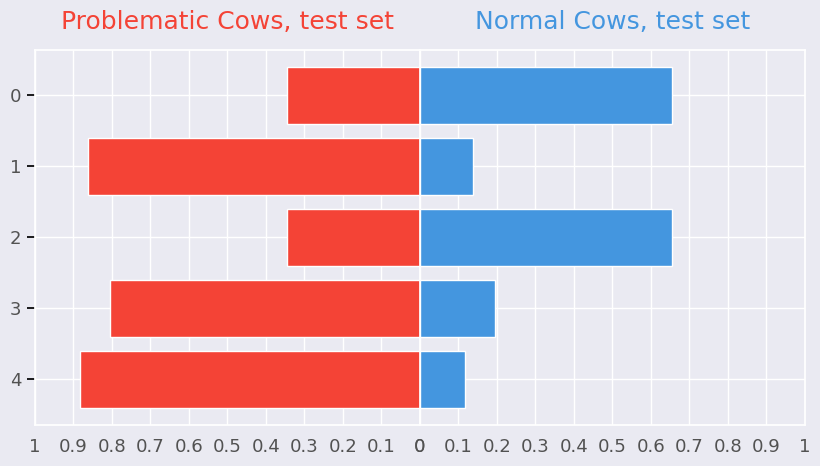

In [272]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
sns.set()

cow_id = X_test.index.copy()
cow_id = cow_id.astype(str)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#f44336'
color_blue = '#4496df'
index = cow_id
column0 = prob_list[:, 0]
column1 = prob_list[:, 1]
title0 = 'Problematic Cows, test set'
title1 = 'Normal Cows, test set'

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=cow_id, yticklabels=cow_id)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black') # tick color

axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
filename = 'Problematic_Cows'
plt.savefig(filename+'.png', facecolor=facecolor)

In [273]:
	# Total_timeDelta_Seconds__minimum

In [274]:
y = pd.DataFrame(ts_dataset['problematic'], columns=['problematic'])
#X = pd.DataFrame(ts_dataset['Total_timeDelta_Seconds__minimum', 'Total_timeDelta_Seconds__root_mean_square'], columns=['Total_timeDelta_Seconds__minimum', 'Total_timeDelta_Seconds__root_mean_square'])

X = pd.DataFrame(ts_dataset['Total_timeDelta_Seconds__minimum'], columns=['Total_timeDelta_Seconds__minimum'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Gaussian Process model with an RBF kernel
kernel = 1.0 * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gpc.fit(X_train, y_train)

# Plot decision boundary with uncertainty
plt.figure(figsize=(10, 5))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Obtain predictions and uncertainties
Z = gpc.predict(np.c_[xx.ravel(), yy.ravel()])
probs_mesh = gpc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  # Probability for class 1
Z = Z.reshape(xx.shape)
probs_mesh = probs_mesh.reshape(xx.shape)

# Plot decision boundaries
plt.contourf(xx, yy, Z, alpha=0.4)

# Plot class probabilities as uncertainty
plt.contourf(xx, yy, probs_mesh, cmap='RdYlBu', alpha=0.2)

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.title('Gaussian Process Classification with Uncertainty')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


InvalidIndexError: (slice(None, None, None), 0)

<Figure size 1000x500 with 0 Axes>